In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
election2016 = pd.read_excel('federalelections2016.xlsx', header=3, nrows=51,
                            sheet_name='Table 2. Electoral &  Pop Vote')

# Crete column index
election2016.set_axis(["State", "Electoral Republicans", "Electorial Democrats", 
                   "Popular Republicans", "Popular Democrats", "Popular Other", "Popular Total"], 
                      axis=1, inplace=True)

# Figure R vs D state
election2016['Party'] = election2016.apply(lambda x:"R" if x['Popular Republicans'] > x['Popular Democrats'] else "D", 
                                           axis=1)
# Only keep party information
election2016=election2016[['State', 'Party']]

# Use State as index
election2016.set_index(['State'], inplace=True)

election2016.head(10)

,Party
State,
AL,R
AK,R
AZ,R
AR,R
CA,D
CO,D
CT,D
DE,D
DC,D


In [3]:
covid = pd.read_csv('United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')

# Only care about number of new death
covid = covid[['submission_date', 'state', 'new_death', 'new_case']]

# Rename columns
covid.set_axis(['Submission Date', 'State', 'Death', 'Case'], axis=1, inplace=True)

covid.set_index(['State'], inplace=True)

covid.head(10)

,Submission Date,Death,Case
State,,,
CO,01/22/2020,0,0
CO,01/23/2020,0,0
CO,01/24/2020,0,0
CO,01/25/2020,0,0
CO,01/26/2020,0,0
CO,01/27/2020,0,0
CO,01/28/2020,0,0
CO,01/29/2020,0,0
CO,01/30/2020,0,0


In [4]:
population2019 = pd.read_excel('nst-est2019-01.xlsx', header=3, nrows=56)
population2019.drop([0,1,2,3,4], inplace=True)
population2019=population2019.iloc[:,-1:]
population2019.set_axis(['Population'], axis=1, inplace=True)
population2019.head(10)

,Population
5,4903185
6,731545
7,7278717
8,3017804
9,39512223
10,5758736
11,3565287
12,973764
13,705749
14,21477737


# Death distributions by party

In [5]:
# Stitching 3 df together
df = election2016.copy()
df['Population'] = population2019['Population'].tolist()
df = df.join(covid)
df.reset_index(inplace=True)
df = df.groupby(['Party', 'Submission Date']).sum()
df.reset_index(inplace=True)
df.head(10)

,Party,Submission Date,Population,Death,Case
0,D,01/22/2020,141449425,0,1
1,D,01/23/2020,141449425,0,0
2,D,01/24/2020,141449425,0,1
3,D,01/25/2020,141449425,0,0
4,D,01/26/2020,141449425,0,2
5,D,01/27/2020,141449425,0,0
6,D,01/28/2020,141449425,0,0
7,D,01/29/2020,141449425,0,0
8,D,01/30/2020,141449425,0,0
9,D,01/31/2020,141449425,0,2


In [6]:
d = df[df['Party']=='D']['Death'].sum()
r = df[df['Party']=='R']['Death'].sum()
print("Total deaths in Democratic states: {}, total deaths in Republican states: {}".format(d, r))

Total deaths in Democratic states: 89739, total deaths in Republican states: 115246


In [7]:
# Normalize by population
d = df[df['Party']=='D']['Death'].sum()/df[df['Party']=='D']['Population'].sum()*100000
r = df[df['Party']=='R']['Death'].sum()/df[df['Party']=='R']['Population'].sum()*100000
print("Total deaths per 100K capita in Democratic states: {}, total deaths per 100K capita in Republican states: {}".format(str(round(d, 3)), str(round(r, 3))))

Total deaths per 100K capita in Democratic states: 0.223, total deaths per 100K capita in Republican states: 0.217


In [8]:
# Rolling 7 days death
df['Rolling 7 Day Death'] = df.rolling(7).mean()['Death']
df['Rolling 7 Day Death Per 100K Capita'] = df.apply(lambda x:x['Rolling 7 Day Death']/x['Population']*100000, 
                                                     axis=1)
# Rolling 7 days case
df['Rolling 7 Day Case'] = df.rolling(7).mean()['Case']
df['Rolling 7 Day Case Per 100K Capita'] = df.apply(lambda x:x['Rolling 7 Day Case']/x['Population']*100000, 
                                                    axis=1)

# Remote Jan since the rolling function "bleed through" across states
df.drop(df[df['Submission Date'].str.match('^01/.?.?/2020')].index, inplace=True)

df.head(10)

,Party,Submission Date,Population,Death,Case,Rolling 7 Day Death,Rolling 7 Day Death Per 100K Capita,Rolling 7 Day Case,Rolling 7 Day Case Per 100K Capita
10,D,02/01/2020,141449425,0,1,0.0,0.0,0.714286,0.000505
11,D,02/02/2020,141449425,0,0,0.0,0.0,0.428571,0.000303
12,D,02/03/2020,141449425,0,3,0.0,0.0,0.857143,0.000606
13,D,02/04/2020,141449425,0,0,0.0,0.0,0.857143,0.000606
14,D,02/05/2020,141449425,0,0,0.0,0.0,0.857143,0.000606
15,D,02/06/2020,141449425,0,0,0.0,0.0,0.857143,0.000606
16,D,02/07/2020,141449425,0,0,0.0,0.0,0.571429,0.000404
17,D,02/08/2020,141449425,0,0,0.0,0.0,0.428571,0.000303
18,D,02/09/2020,141449425,0,0,0.0,0.0,0.428571,0.000303
19,D,02/10/2020,141449425,0,0,0.0,0.0,0.000000,0.000000


In [9]:
rollingDeath = pd.pivot_table(df, values='Rolling 7 Day Death Per 100K Capita', index=['Submission Date'],
                    columns=['Party'])
rollingDeath = rollingDeath.iloc[0::7,:]
rollingCase = pd.pivot_table(df, values='Rolling 7 Day Case Per 100K Capita', index=['Submission Date'],
                    columns=['Party'])
rollingCase = rollingCase.iloc[0::7,:]

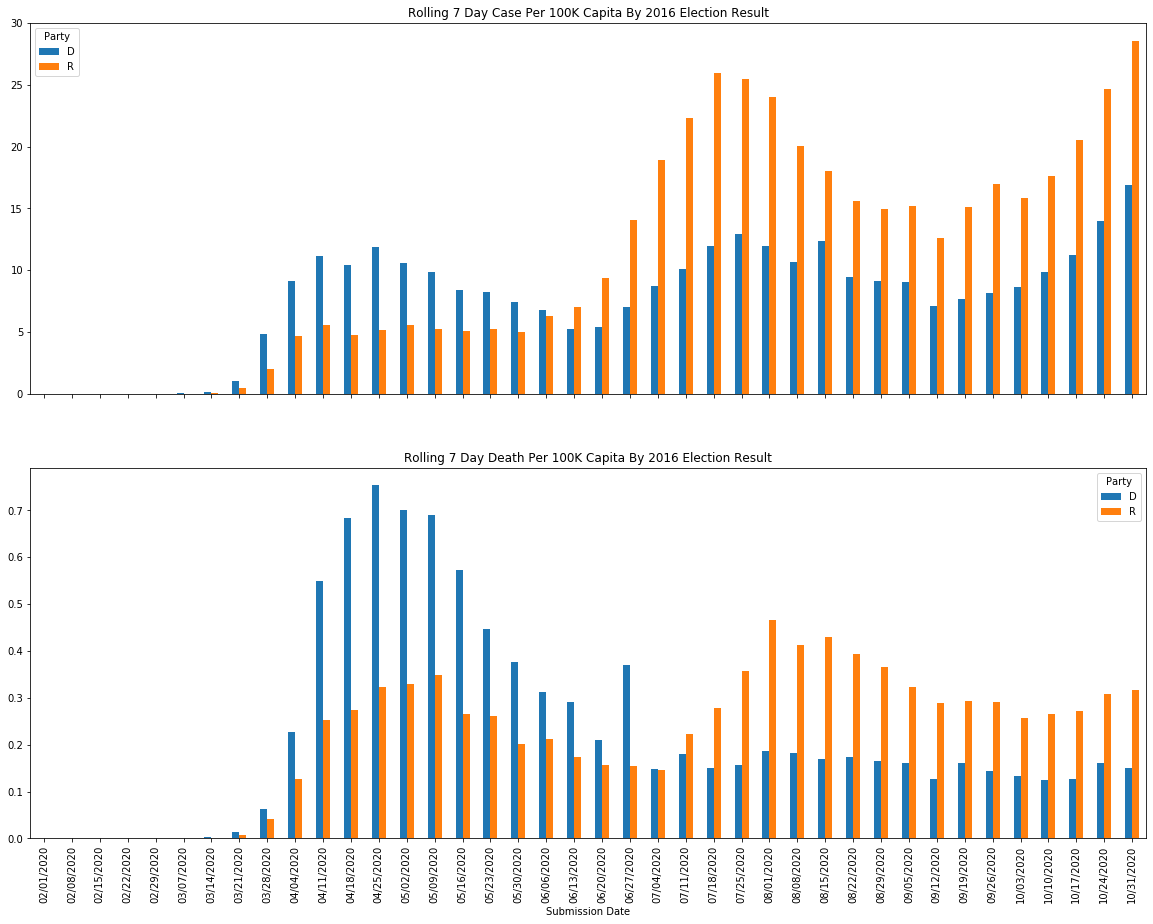

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 15), sharex=True, sharey=False, constrained_layout=False)
rollingCase.plot(ax=axes[0], kind="bar", title="Rolling 7 Day Case Per 100K Capita By 2016 Election Result")
rollingDeath.plot(ax=axes[1], kind="bar", title="Rolling 7 Day Death Per 100K Capita By 2016 Election Result")

# Death distributions by state

In [11]:
# Stitching 3 df together
df = election2016.copy()
df['Population'] = population2019['Population'].tolist()
df = df.join(covid)
df.reset_index(inplace=True)
df = df.groupby(['Party', 'State', 'Submission Date']).sum()
df.reset_index(inplace=True)
df.head(10)

,Party,State,Submission Date,Population,Death,Case
0,D,CA,01/22/2020,39512223,0,0
1,D,CA,01/23/2020,39512223,0,0
2,D,CA,01/24/2020,39512223,0,0
3,D,CA,01/25/2020,39512223,0,0
4,D,CA,01/26/2020,39512223,0,2
5,D,CA,01/27/2020,39512223,0,0
6,D,CA,01/28/2020,39512223,0,0
7,D,CA,01/29/2020,39512223,0,0
8,D,CA,01/30/2020,39512223,0,0
9,D,CA,01/31/2020,39512223,0,1


In [12]:
# Rolling 7 days death
df['Rolling 7 Day Death'] = df.rolling(7).mean()['Death']
df['Rolling 7 Day Death Per 100K Capita'] = df.apply(lambda x:x['Rolling 7 Day Death']/x['Population']*100000, 
                                                     axis=1)
# Rolling 7 days case
df['Rolling 7 Day Case'] = df.rolling(7).mean()['Case']
df['Rolling 7 Day Case Per 100K Capita'] = df.apply(lambda x:x['Rolling 7 Day Case']/x['Population']*100000, 
                                                    axis=1)

# Remote Jan since the rolling function "bleed through" across states
df.drop(df[df['Submission Date'].str.match('^01/.?.?/2020')].index, inplace=True)

df.head(10)

,Party,State,Submission Date,Population,Death,Case,Rolling 7 Day Death,Rolling 7 Day Death Per 100K Capita,Rolling 7 Day Case,Rolling 7 Day Case Per 100K Capita
10,D,CA,02/01/2020,39512223,0,0,0.0,0.0,0.428571,0.001085
11,D,CA,02/02/2020,39512223,0,0,0.0,0.0,0.142857,0.000362
12,D,CA,02/03/2020,39512223,0,3,0.0,0.0,0.571429,0.001446
13,D,CA,02/04/2020,39512223,0,0,0.0,0.0,0.571429,0.001446
14,D,CA,02/05/2020,39512223,0,0,0.0,0.0,0.571429,0.001446
15,D,CA,02/06/2020,39512223,0,0,0.0,0.0,0.571429,0.001446
16,D,CA,02/07/2020,39512223,0,0,0.0,0.0,0.428571,0.001085
17,D,CA,02/08/2020,39512223,0,0,0.0,0.0,0.428571,0.001085
18,D,CA,02/09/2020,39512223,0,0,0.0,0.0,0.428571,0.001085
19,D,CA,02/10/2020,39512223,0,0,0.0,0.0,0.000000,0.000000


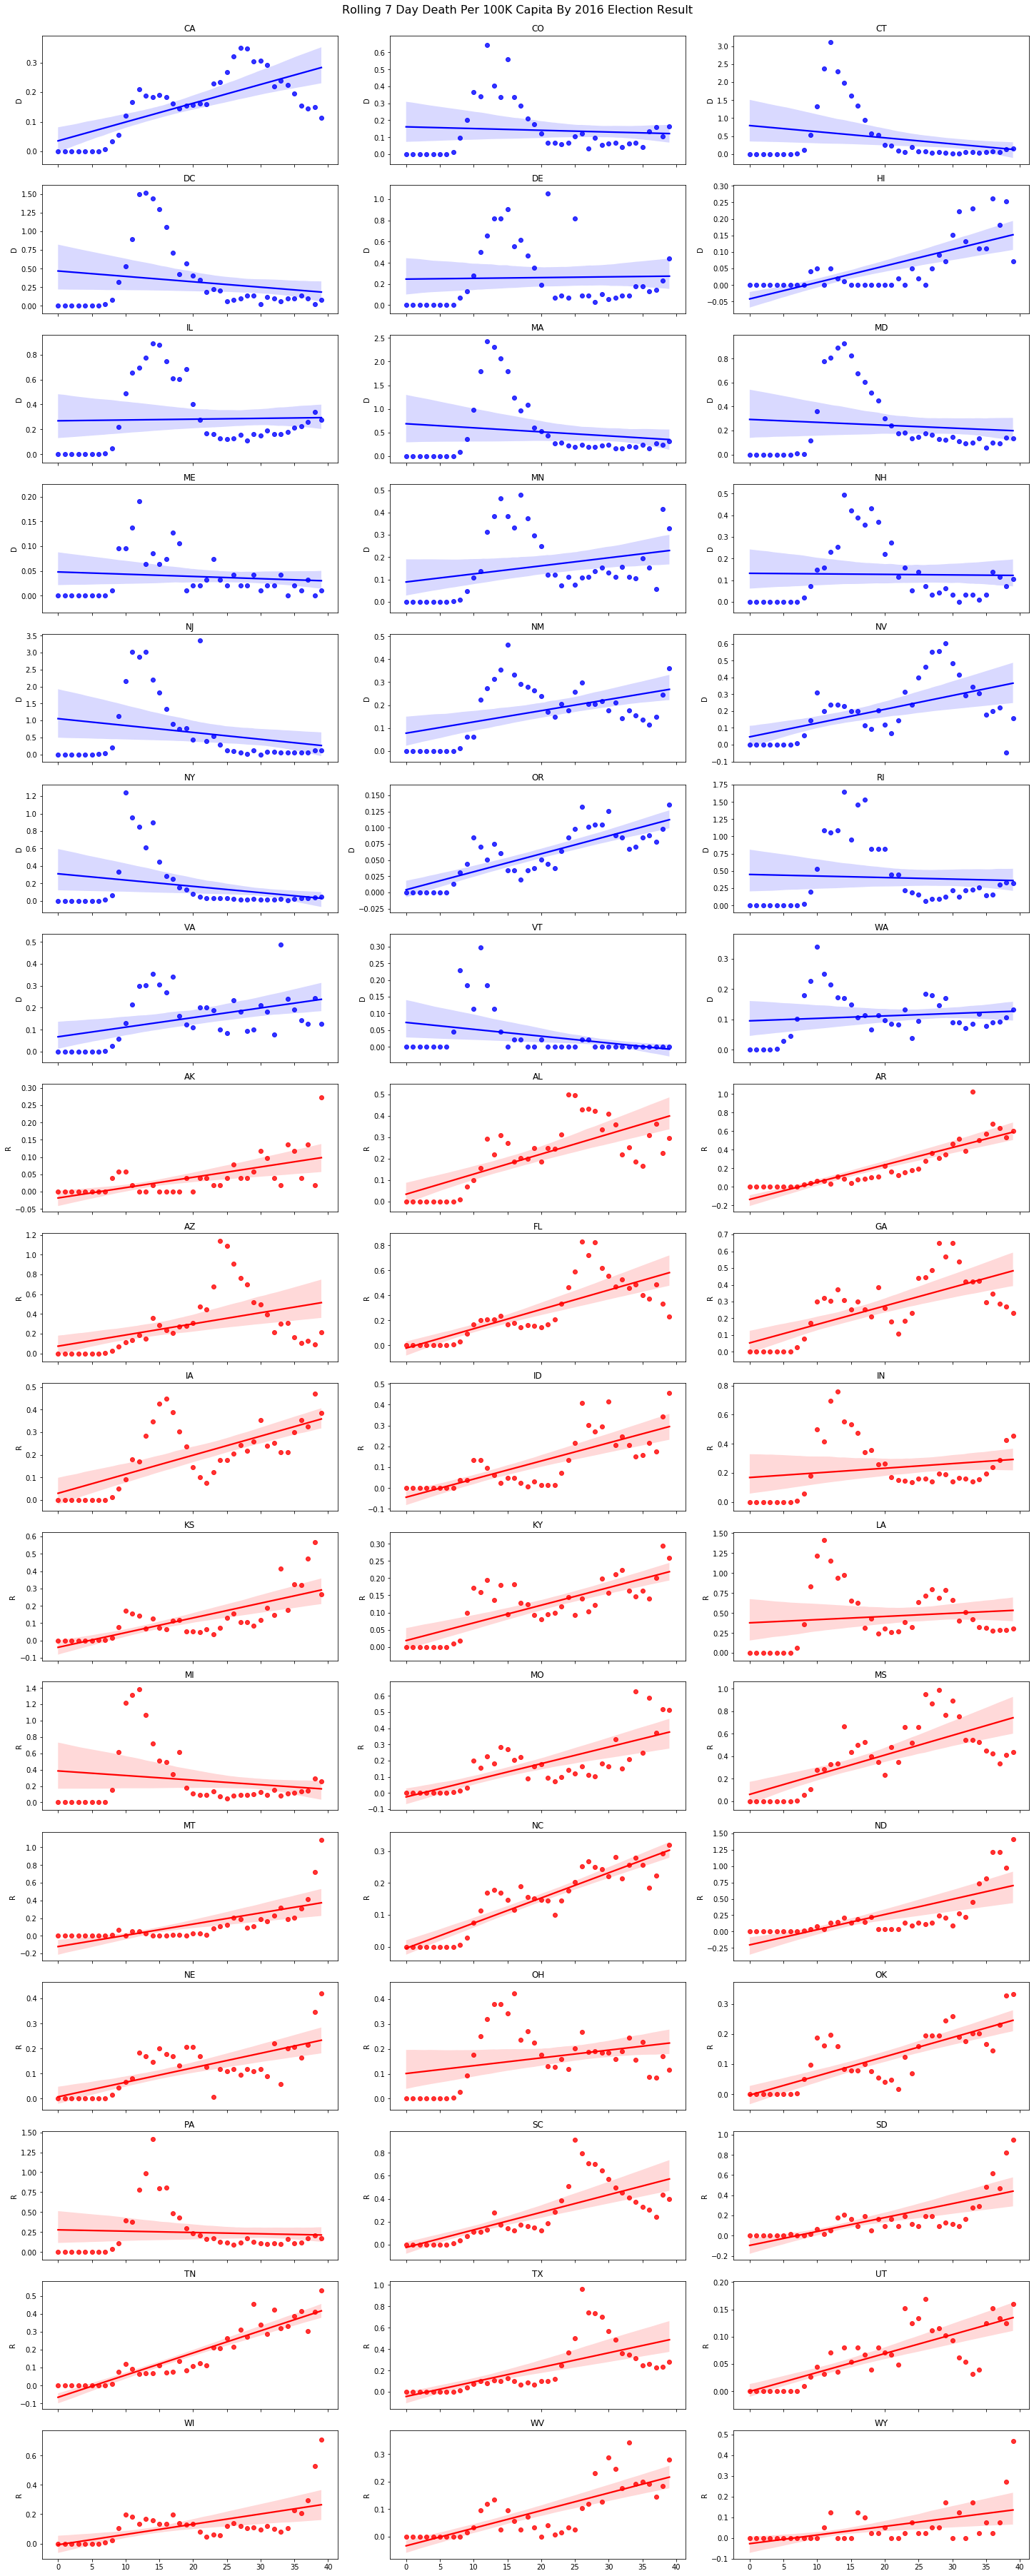

In [14]:

i = 0
n_plots = len(df['State'].unique())
#n_plots = 6
ncols = 3
nrows = math.ceil(float(n_plots)/ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 50), sharex=True, sharey=False, constrained_layout=True)
fig.suptitle("Rolling 7 Day Death Per 100K Capita By 2016 Election Result", fontsize=16)
for row in axes:
    for ax in row:
        if i >= n_plots:
            continue
        state = df['State'].unique().tolist()[i]
        sub_df = df.loc[df['State']==state].iloc[0::7,:]
        rollingDeath = pd.pivot_table(sub_df, values='Rolling 7 Day Death Per 100K Capita', index=['Submission Date'],
                            columns=['State', 'Party'])
        party = rollingDeath.columns.levels[1][0]
        rollingDeath.reset_index(inplace=True)
        c ='b' if party=='D' else 'r'
        #ax.scatter(x = rollingDeath.index, y = rollingDeath[state], c = c)
        sns.regplot(ax=ax, x = rollingDeath.index, y = rollingDeath[state], color=c);
        ax.set_title(state)

        i += 1